/home/johns/anaconda3/envs/PFC_env/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Running episodes with agent Network:  33%|██████████████▌                             | 1649/5000 [7:56:54<16:39:49, 17.90s/it]

device = cuda:1


Running episodes with agent Network:   0%|                                                            | 0/5000 [00:00<?, ?it/s]

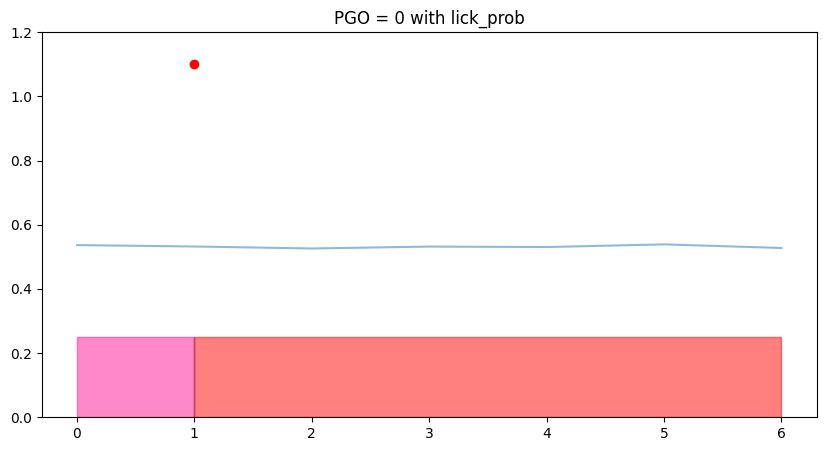

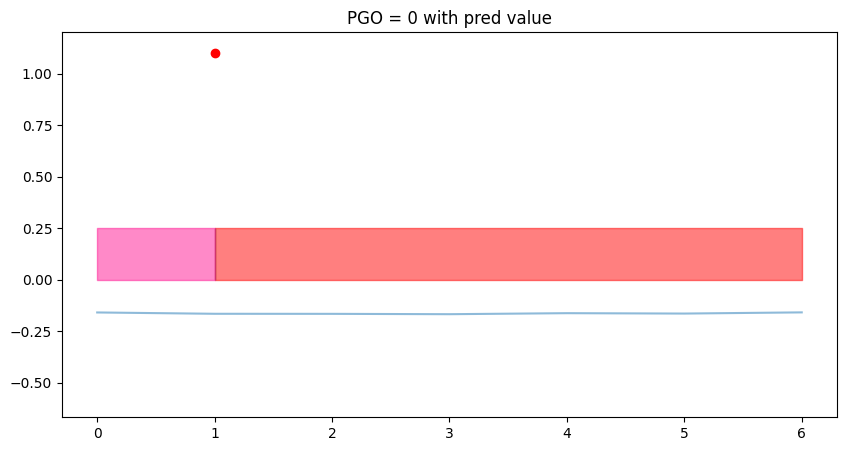

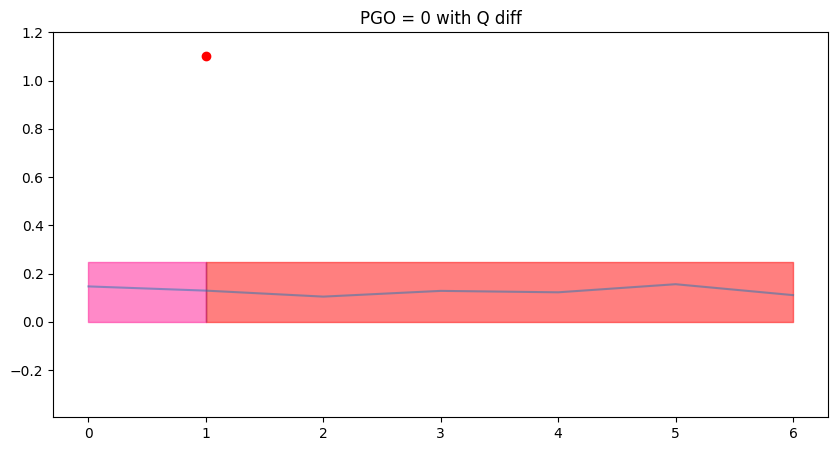

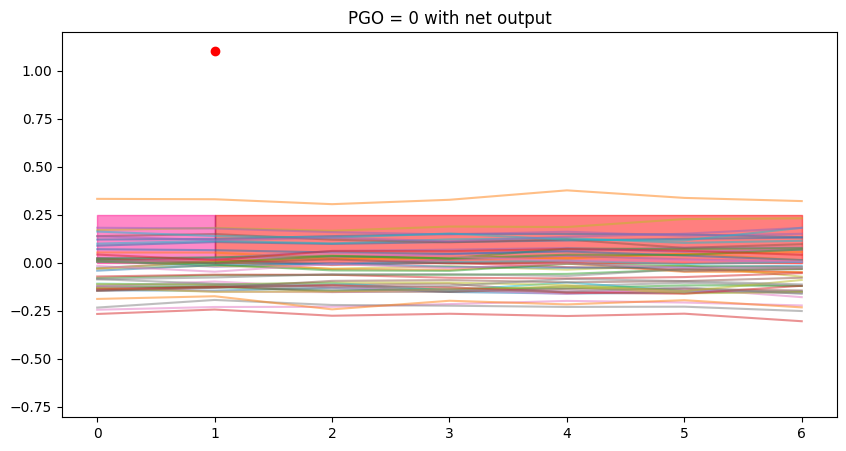

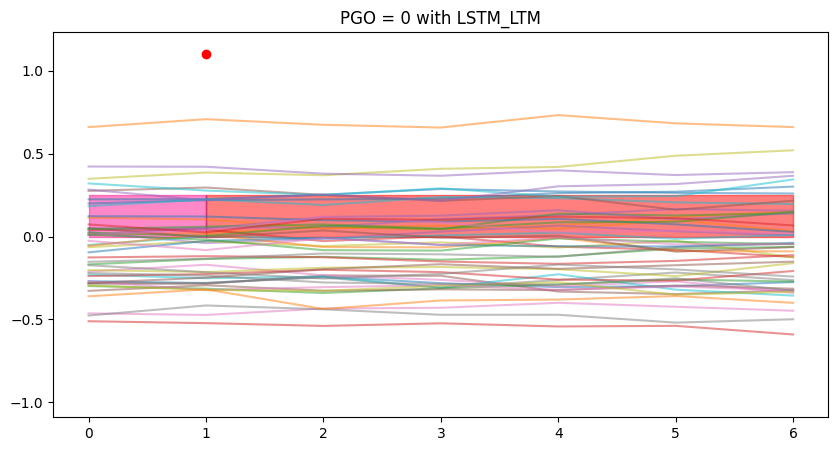

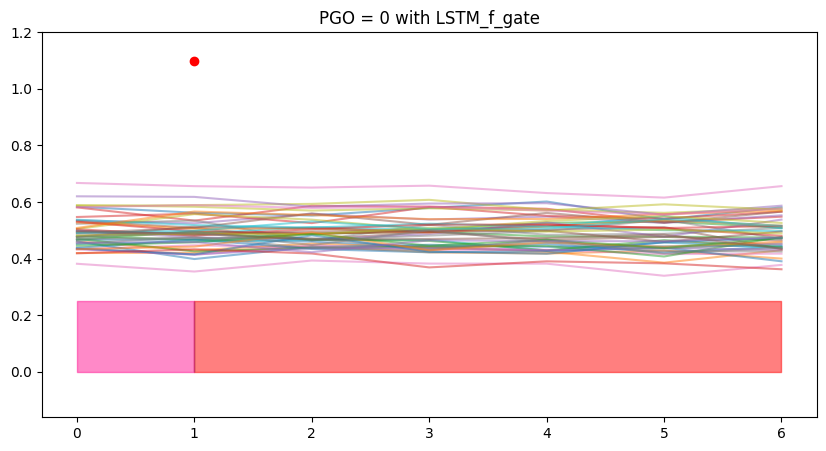

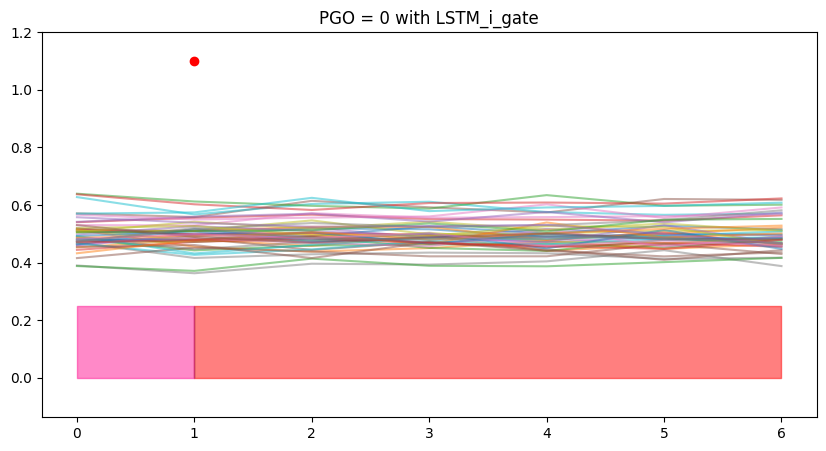

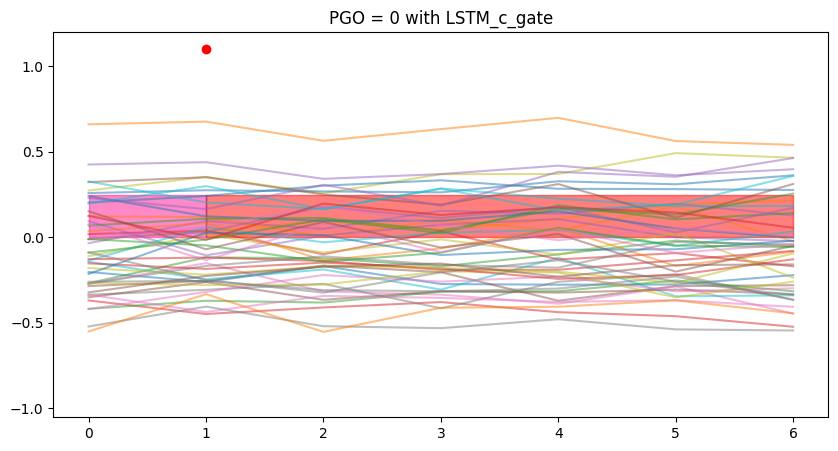

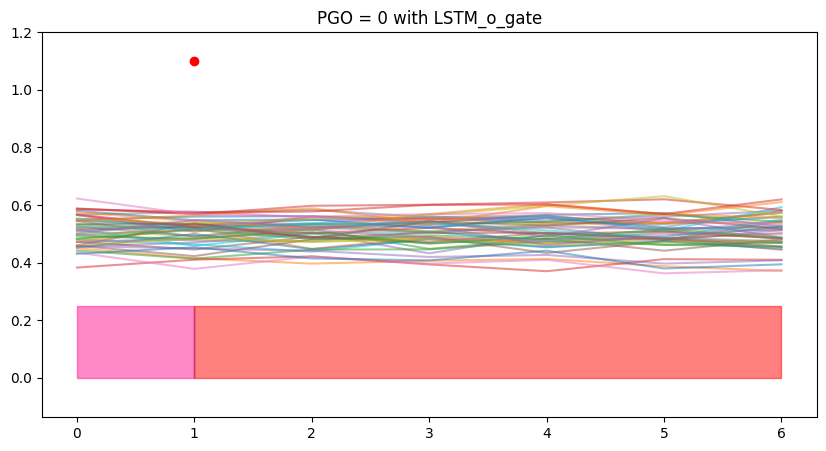

Running episodes with agent Network:   1%|▌                                               | 53/5000 [12:23<22:32:39, 16.41s/it]

In [1]:
from enzyme.src.main.run_simulation import run_simulation; import torch; 
from enzyme.src.network.Actor_Critic import Actor_Critic;  
from enzyme.src.mouse_task.mouse_task import mouse_task_; 
import bz2; import pickle; import _pickle as c; 
from enzyme.src.mouse_task.data_structures import cage_data_struct

def manage_data_storage(manager = None, operation = None, path = None, name = None):
    if operation == 'save_behavior':
        data = manager.data.to_dictionary()   
        with bz2.BZ2File(path + name + '.pkbz2', 'w' , compresslevel = 1) as f: 
            c.dump(data, f) 
            
    elif operation == 'save_matlab':
        manager.data.remove_tensors()
        data = manager.data.to_dictionary()   
        with open(path + name + '.pickle', 'wb') as f: 
            pickle.dump(data, f)    
                
    elif operation == 'load_pickle':
        with open(path + name + '.pickle', 'rb') as f: 
            data = c.load(f)
        manager.data.from_dictionary(data)
#        manager.sim.preprocess_data(manager)

    elif operation == 'load_pkbz':
        data = c.load(bz2.BZ2File(path + name + '.pkbz2', 'rb'))
        manager.data.from_dictionary(data)
        manager.sim.preprocess_data(manager)
        
        
cuda = 'cuda:1' 
mode = 'LSTM_mem'                      # ['LSTM', 'RNN']
prefix = 'LSTM_mem_readout' 
pretrained = None 
handmade = True
get_dynamics_of = 'actor'        # ['actor', 'critic']
subnets = None                     # [None, 'bayes', 'bayes_optim', 'dynamics', 'factorized', 'factorized_optim']
lesion =  []                       # [None, 'INPUT', 'OUTPUT', 'FORGET', 'LTM', 'STM', 'LTM_bound']      # training with bound, testing without bound for OFC
regress_on = ["CELL"]              # ["CELL", "FORGET", "INPUT", "OUTPUT", "STM", "LTM"]
hid_dim = int(4*48) if mode == 'RNN' else 48 
max_traj_steps = 24
give_ctx = False

train = True
train_recurrent = True
inp = 'one_hot' #['raw', 'one_hot', 'diff']
discount = .995 
lr = .001#.00005 for RNN #.001 for subnets

ITI_mean = 15
ITI_PM = 10

act_dim = 2
momentum = 0
ent_bonus = 0
value_beta = .1 
if inp == 'one_hot':
    inp_dim = 5 
if inp == 'raw' or inp == 'diff':
    inp_dim = 3
inp_dim = inp_dim + give_ctx

net_filename = prefix + '_net.pth'
data_filename =  prefix
device = cuda if torch.cuda.is_available() else 'cpu'
print(f"device = {device}")
from enzyme import PRJ_ROOT
save_path = PRJ_ROOT / str('Data/')

loss_params = {'discount' : discount, 'B_val' : value_beta, 'B_ent': ent_bonus, 'decrease_entropy' : False}
network_params = {'inp_dim': inp_dim, 'hid_dim' : hid_dim, 'act_dim' : act_dim, 'device' : device, 'mode' : mode, 'get_dynamics_of' : get_dynamics_of, 
    'expansion' : None, 'pavlovian_bias' : False, 'lesion': lesion, 'handmade': handmade, 'subnets': subnets, 'RAP' : 0,
    'use_vanilla_torch': False, 'train_recurrent' : train_recurrent, 'eran_policy': False}

optim_params = {'lr' : lr, 'alpha' : .99, 'eps' : 1e-5, 'weight_decay' : .0, 'momentum' : momentum, 'centered' : False}
agent_params = dict(loss_params, **optim_params, **network_params)  
agent = Actor_Critic(**agent_params)
if pretrained is not None:
    agent.load_state_dict(torch.load(save_path / str(f'{pretrained}'), map_location=torch.device(device)))

mouse_task_params = {'sim_ID' : 3, 'save_path' : save_path, 'act_dim' : act_dim, 'exp_mean': 10, 'exp_max': 50,  'W4L': 35, 'ITI_mean' : ITI_mean, 'ITI_PM' : ITI_PM, 'store_tensors' : False, 'ignore_action' : False, 
     'give_ctx': give_ctx, 'plant_type' : 'random', 'end_NOGO': False, 'start_NOGO': False, 'regress_on' : regress_on, 'max_traj_steps': max_traj_steps, 'basis_on' : 'output', 'plant_prob': 0, 'neg_rew' : 0, 'theta_traj' : None}
manager_params = {'training' : True, 'input': inp, 'device' : device}  
 
if train:
    """train agent"""
    mouse_task_params['PGO_range'] =  [0, .15, .3, .45, .6, .75, .9] # [.1, .3, .5, .7, .9]
    mouse_task_params['episodes'] = 5000
    mouse_task_params['num_trials'] = 500
    mouse_task_params['exp_min'] = 4
    training_sim_params = dict(agent_params, **mouse_task_params, **manager_params)            
    training = run_simulation(mouse_task_, training_sim_params, agent, plot_episode = True)
    training.sim.plot_all_episodes(training)    
         
    """Save agent"""
    torch.save(agent.state_dict(), save_path / str(f'{net_filename}'))
    # manage_data_storage(manager = training, operation = 'save_behavior', path = save_path / str('behavior'), name = data_filename)

"""Load agent"""                                                             
agent.load_state_dict(torch.load(save_path / str(f'{net_filename}'), map_location=torch.device(device)))

"""Set up testing parameters"""
mouse_task_params['PGO_range'] = [.1, .2, .3, .4, .5, .6 , .7, .8, .9]
mouse_task_params['plant_type'] = 'random'
mouse_task_params['ignore_action'] = False
mouse_task_params['end_NOGO'] = True
mouse_task_params['plant_prob'] = 0#.1
mouse_task_params['episodes'] = 5000
mouse_task_params['num_trials'] = 20
mouse_task_params['exp_min'] = 1

"""run testing"""
manager_params['training'] = False
mouse_task_params['store_tensors'] = True
testing_sim_params = dict(agent_params, **mouse_task_params, **manager_params)
testing = run_simulation(mouse_task_, testing_sim_params, agent, plot_episode = True)
testing.sim.plot_all_episodes(testing)
